In [8]:
#imports
import pandas as pd
import numpy as np
import math as mat
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from matplotlib.colors import ListedColormap
from datetime import datetime



In [9]:
data1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assig 4 Logistics Reg with bicicles/train_set.csv')
#data2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assig 4 Logistics Reg with bicicles/test_set.csv')

In [10]:
data1.head(10)

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
0,101750280,35,2018-08-07 11:20:00,2018-08-07 11:55:00,33.748920,-118.275192,33.748920,-118.275192,06530,1.0,Round Trip,Walk-up,4127,4127
1,46560345,32,9/17/2017 17:51,9/17/2017 18:23,34.035679,-118.270813,34.047749,-118.243172,6683,0.0,One Way,Walk-up,3057,3062
2,120016336,6,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,06710,30.0,One Way,Monthly Pass,3022,3062
3,129547190,138,9/22/2019 11:27,9/22/2019 13:45,34.062580,-118.290092,34.059689,-118.294662,17068,1.0,One Way,One Day Pass,4304,4311
4,136619463,14,1/31/2020 17:11,1/31/2020 17:25,34.026291,-118.277687,34.021660,-118.278687,18841,30.0,One Way,Monthly Pass,4266,4443
5,63406498,30,2017-12-16 15:18:00,2017-12-16 15:48:00,34.135250,-118.132370,34.135250,-118.132370,05768,0.0,Round Trip,Walk-up,4158,4158
6,25033469,11,2017-04-15 22:02:00,2017-04-15 22:13:00,34.045181,-118.250237,34.053570,-118.266357,06527,30.0,One Way,Monthly Pass,3067,3040
7,107479459,15,2018-10-16 17:27:00,2018-10-16 17:42:00,34.041130,-118.267982,34.045422,-118.253517,06333,1.0,One Way,Walk-up,3011,3051
8,132750788,19,2019-11-16 11:24:27,2019-11-16 11:43:49,34.046822,-118.248352,34.046822,-118.248352,19855,30.0,Round Trip,Monthly Pass,3038,3038
9,107465757,8,2018-10-16 12:05:00,2018-10-16 12:13:00,34.052872,-118.247490,34.046070,-118.233093,05926,1.0,One Way,Walk-up,3046,3022


In [65]:
data1['passholder_type'].nunique

<bound method IndexOpsMixin.nunique of 0              Walk-up
1              Walk-up
2         Monthly Pass
3         One Day Pass
4         Monthly Pass
              ...     
699995    Monthly Pass
699996    Monthly Pass
699997       Flex Pass
699998         Walk-up
699999         Walk-up
Name: passholder_type, Length: 693618, dtype: object>

In [11]:
data1.shape

(700000, 14)

In [12]:
data1.isna().sum()

trip_id                    0
duration                   0
start_time                 0
end_time                   0
start_lat               5563
start_lon               5563
end_lat                18574
end_lon                18574
bike_id                    0
plan_duration            208
trip_route_category        0
passholder_type         2576
start_station              0
end_station                0
dtype: int64

In [13]:
data1['end_time'].max()

'9/9/2020 9:57'

In [14]:
data1['end_time'].min()

'1/1/2017 0:23'

In [15]:
data1.dtypes

trip_id                  int64
duration                 int64
start_time              object
end_time                object
start_lat              float64
start_lon              float64
end_lat                float64
end_lon                float64
bike_id                 object
plan_duration          float64
trip_route_category     object
passholder_type         object
start_station            int64
end_station              int64
dtype: object

###Feature preparation

In [16]:
data1['end_time'] = pd.to_datetime(data1['end_time'],yearfirst=True)


In [17]:
data1['start_time'] = pd.to_datetime(data1['start_time'],yearfirst=True)

In [18]:
def timemin(s1,s2):

  return pd.Timedelta(s2 - s1).seconds/60

In [19]:
data1['time'] = data1.apply(lambda x: timemin(s2=x['end_time'], s1 = x['start_time']),axis=1)

In [20]:
data1['time']

0          35.000000
1          32.000000
2           6.000000
3         138.000000
4          14.000000
             ...    
699995     17.000000
699996      9.683333
699997      6.000000
699998      3.000000
699999     59.000000
Name: time, Length: 700000, dtype: float64

In [21]:
data1['time'].max()

1439.0

In [22]:
count = data1[data1['time'] >=500]
count.shape

(6395, 15)

In [23]:
data1 = data1[data1['time'] <=500]

In [24]:
import geopy.distance

In [25]:
df = data1.copy()

In [26]:
df = df.dropna()

In [27]:
def hess(a,al,b,bl):
  coords_1 = (a, al)
  coords_2 = (b, bl)

  return geopy.distance.geodesic(coords_1, coords_2).km

In [28]:
df['distance_km'] = df.apply(lambda x: hess(a=x['start_lat'], al = x['start_lon'], b= x['end_lat'],bl= x['end_lon']),axis=1)

In [29]:
df['distance_km'].head()

0    0.000000
1    2.882193
2    0.949087
3    0.529935
4    0.521920
Name: distance_km, dtype: float64

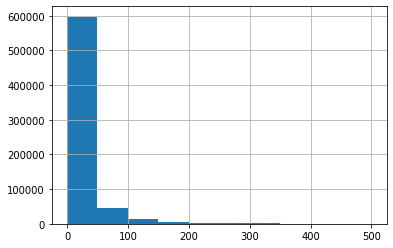

In [152]:
df['time'].hist()

###Logistic Regression

In [30]:
df1 = df

In [31]:
df.head()

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station,time,distance_km
0,101750280,35,2018-08-07 11:20:00,2018-08-07 11:55:00,33.748920,-118.275192,33.748920,-118.275192,06530,1.0,Round Trip,Walk-up,4127,4127,35.0,0.000000
1,46560345,32,2017-09-17 17:51:00,2017-09-17 18:23:00,34.035679,-118.270813,34.047749,-118.243172,6683,0.0,One Way,Walk-up,3057,3062,32.0,2.882193
2,120016336,6,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,06710,30.0,One Way,Monthly Pass,3022,3062,6.0,0.949087
3,129547190,138,2019-09-22 11:27:00,2019-09-22 13:45:00,34.062580,-118.290092,34.059689,-118.294662,17068,1.0,One Way,One Day Pass,4304,4311,138.0,0.529935
4,136619463,14,2020-01-31 17:11:00,2020-01-31 17:25:00,34.026291,-118.277687,34.021660,-118.278687,18841,30.0,One Way,Monthly Pass,4266,4443,14.0,0.521920


In [32]:
df1[df1['distance_km'] >=100].shape

(98, 16)

In [33]:
df1 =df1[df1['distance_km'] <=100]

In [34]:
df1[df1['distance_km'] >=100].shape

(0, 16)

In [35]:
def transform(x):
    if x == "Monthly Pass":
      return 1
    else:
      return 0


In [36]:
df1["passholder_type"] = df1['passholder_type'].map(transform)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
df1['passholder_type'].nunique()

2

In [38]:
# Shuffle your dataset 
shuffle_df = df1.sample(frac=1)

# Define a size for your train set 
train_size = int(0.9 * len(df1))

# Split your dataset 
train_df = shuffle_df[:train_size]
test_df = shuffle_df[train_size:]

In [39]:
def norma(data):
  return (data-data.min())/(data.max()-data.min())

In [40]:
X = train_df.loc[:,['time','distance_km']]
y = train_df.loc[:,'passholder_type']

In [41]:
X.shape

(604384, 2)

In [59]:
Xnorm = norma(X)

In [43]:
X_test = test_df.loc[:,['time','distance_km']]
y_test = test_df.loc[:,'passholder_type']

In [60]:
Xtestnorm = norma(X_test)

In [45]:
X_test.shape

(67154, 2)

In [46]:
X = X.to_numpy()
y = y.to_numpy()

In [47]:
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [48]:
y_test

array([0, 1, 1, ..., 1, 0, 1])

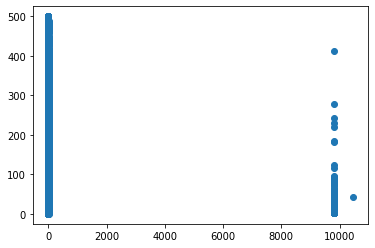

In [49]:
plt.scatter(df['distance_km'],df['time'])

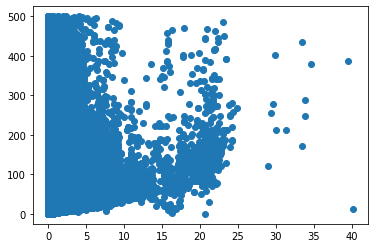

In [50]:
plt.scatter(df1['distance_km'],df1['time'])

In [51]:
df1.max()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


trip_id                          179457605
duration                              1440
start_time             2021-12-31 22:57:00
end_time               2022-01-01 21:35:00
start_lat                        55.705528
start_lon                        37.606541
end_lat                          55.705528
end_lon                          37.606541
plan_duration                        999.0
trip_route_category             Round Trip
passholder_type                          1
start_station                         4594
end_station                           4594
time                                 500.0
distance_km                      40.131137
dtype: object

###Neuronal network 


In [52]:
def linear(H):
  return H

def ReLU(H):
  return H*(H>0)

def sigmoid(H):
  return 1/(1+np.exp(-H))

def softmax(H):
  eH=np.exp(H)
  return eH/eH.sum(axis=1,keepdims=True)

def cross_entropy(Y, P_hat):
  return -(1/len(Y))*np.sum(Y*np.log(P_hat))

def OLS(Y, Y_hat):
  return (1/(2*len(Y)))*np.sum((Y-Y_hat)**2)

def one_hot_encode(y):
  N=len(y)
  K=len(set(y))
  Y=np.zeros((N,K))

  for i in range(N):
    Y[i, y[i]]=1

  return Y

def accuracy(y, y_hat):
  return np.mean(y==y_hat)

def R2(y, y_hat):
  return 1-np.sum((y-y_hat)**2)/np.sum((y -y.mean())**2)

# Derivatives of Activation functions

def derivative(Z,a):
  if a==linear:
    return 1
  elif a==sigmoid:
    return Z*(1-Z)
  elif a==np.tanh:
    return 1-Z*Z
  elif a==ReLU:
    return (Z>0).astype(int)
  else:
    ValueError("Unknown Activation Function")


In [53]:
cmap_bold = ListedColormap(["#FF0000","#00FF00","#0000FF"])
cmap_light = ListedColormap(["#FFBBBB","#BBFFBB","#BBBBFF"])

In [54]:
class ANN():

  def __init__(self,architecture, activations=None, mode=0):
    self.mode=mode
    self.architecture=architecture
    self.activations=activations
    self.L = len(architecture)+1

  def fit(self, X, y, eta=1e-3, epochs=1e3, show_curve=False):
    epochs=int(epochs)
    if self.mode:
      Y=y
    else:
      Y=one_hot_encode(y)
    
    N,D =X.shape
    K=Y.shape[1]

    #Weights Init
    self.W={l: np.random.randn(M[0],M[1]) for l, M in enumerate
            (zip(([D]+self.architecture),(self.architecture+[K])),1)}
    self.b={l:np.random.randn(M) for l, M in enumerate(self.architecture +[K],1)}
    #Activations Loading
    if self.activations is None:
      self.a={l: ReLU for l in range(1,self.L)}
    else:
      self.a={l: act for l, act in enumerate(self.activations,1)}
    
    #Outputs
    if self.mode:
      self.a[self.L]=linear
    else:
      self.a[self.L]=softmax

    J = np.zeros(epochs)

    #GradDesc and Back Propagation
    for epoch in range(epochs):
      self.forward(X)
      if self.mode:
        J[epoch]= OLS(Y, self.Z[self.L])
      else:
        J[epoch]=cross_entropy(Y, self.Z[self.L])

      dH = (1/N)*(self.Z[self.L]-Y)

      for l in sorted(self.W.keys(), reverse=True):
        dW = self.Z[l-1].T@dH
        db = dH.sum(axis=0)
        #update rules
        self.W[l] -= eta*dW
        self.b[l] -= eta*db

        if l>1:
          dZ = dH@self.W[l].T
          dH = dZ*derivative(self.Z[l-1], self.a[l-1])

    if show_curve:
        plt.figure()
        plt.plot(J)
        plt.xlabel("epochs")
        plt.ylabel("$\mathcal{J}$")
        plt.show()

  def forward(self, X):
    self.Z={0:X}
    for l in sorted(self.W.keys()):
      self.Z[l]=self.a[l](self.Z[l-1]@self.W[l]+self.b[l])
  
  def predict(self, X):
    self.forward(X)
    if self.mode:
      return self.Z[self.L]
    else:
      return self.Z[self.L].argmax(axis=1)

In [55]:
def main_class():
    D = 2
    K = 3
    N = int(K*1e3)
    

    ann=ANN([8, 8, 8],[ReLU, np.tanh, np.tanh])
    ann.fit(X,y, eta =3e-2, epochs=2e3, show_curve=True)
    y_hat = ann.predict(X)
    y_hatt = ann.predict(X_test)

    print(f"Training Accuracy: {accuracy(y, y_hat):0.4f}")
    print(f"Test Accuracy: {accuracy(y_test, y_hatt):0.4f}")
    
    x1 = np.linspace(X[:,0].min() - 1, X[:,0].max() + 1, 1000)
    x2 = np.linspace(X[:,1].min() - 1, X[:,1].max() + 1, 1000)
    
    xx1, xx2 = np.meshgrid(x1, x2)
    Z = ann.predict(np.c_[xx1.ravel(),xx2.ravel()]).reshape(*xx1.shape)
    
    plt.figure()
    plt.pcolormesh(xx1, xx2, Z, cmap = cmap_light)
    plt.scatter(X[:,0], X[:,1], c = y, cmap = cmap_bold,alpha=0.2)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plt.show()    

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

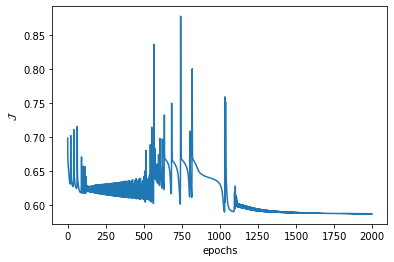

Training Accuracy: 0.6966
Test Accuracy: 0.6994


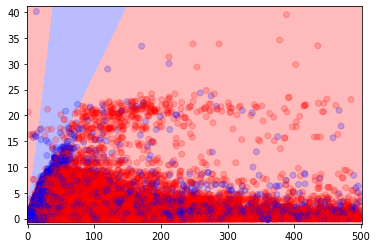

In [56]:
if __name__ =="__main__":
  main_class()

#Data norm

In [61]:
def main_class2():
    D = 2
    K = 3
    N = int(K*1e3)
    

    ann=ANN([8, 8, 8],[ReLU, np.tanh, np.tanh])
    ann.fit(Xnorm,y, eta =1e-2, epochs=2e3, show_curve=True)
    y_hat = ann.predict(Xnorm)
    y_hatt = ann.predict(Xtestnorm)

    print(f"Training Accuracy: {accuracy(y, y_hat):0.4f}")
    print(f"Test Accuracy: {accuracy(y_test, y_hatt):0.4f}")
    
    x1 = np.linspace(X[:,0].min() - 1, X[:,0].max() + 1, 1000)
    x2 = np.linspace(X[:,1].min() - 1, X[:,1].max() + 1, 1000)
    
    xx1, xx2 = np.meshgrid(x1, x2)
    Z = ann.predict(np.c_[xx1.ravel(),xx2.ravel()]).reshape(*xx1.shape)
    
    plt.figure()
    plt.pcolormesh(xx1, xx2, Z, cmap = cmap_light)
    plt.scatter(X[:,0], X[:,1], c = y, cmap = cmap_bold,alpha=0.2)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plt.show()    

In [62]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Sep  7 01:36:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

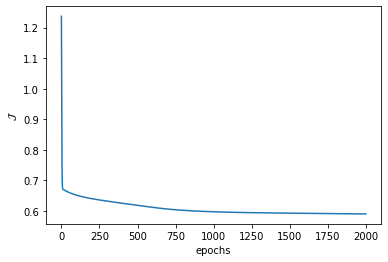

Training Accuracy: 0.6994
Test Accuracy: 0.7011


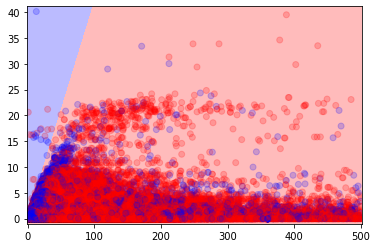

In [63]:
if __name__ =="__main__":
  main_class2()

###80-20

In [135]:
# Shuffle your dataset 
shuffle_df = df1.sample(frac=1)

# Define a size for your train set 
train_size = int(0.8 * len(df1))

# Split your dataset 
train_df = shuffle_df[:train_size]
test_df = shuffle_df[train_size:]

In [136]:
X8 = train_df.loc[:,['time','distance_km']]
y8 = train_df.loc[:,'passholder_type']

In [137]:
X8 = X8.to_numpy()
y8 = y8.to_numpy()

In [138]:
X_test8 = test_df.loc[:,['time','distance_km']]
y_test8 = test_df.loc[:,'passholder_type']

In [139]:
X_test8 = X_test8.to_numpy()
y_test8 = y_test8.to_numpy()

In [140]:
def main_class8():
    D = 2
    K = 3
    N = int(K*1e3)
    

    ann=ANN([8, 8, 8],[ReLU, np.tanh, np.tanh])
    ann.fit(X8,y8, eta =1e-2, epochs=2e3, show_curve=True)
    y_hat = ann.predict(X8)
    y_hatt = ann.predict(X_test8)

    print(f"Training Accuracy: {accuracy(y8, y_hat):0.4f}")
    print(f"Test Accuracy: {accuracy(y_test8, y_hatt):0.4f}")
    
    x1 = np.linspace(X[:,0].min() - 1, X[:,0].max() + 1, 1000)
    x2 = np.linspace(X[:,1].min() - 1, X[:,1].max() + 1, 1000)
    
    xx1, xx2 = np.meshgrid(x1, x2)
    Z = ann.predict(np.c_[xx1.ravel(),xx2.ravel()]).reshape(*xx1.shape)
    
    plt.figure()
    plt.pcolormesh(xx1, xx2, Z, cmap = cmap_light)
    plt.scatter(X[:,0], X[:,1], c = y, cmap = cmap_bold,alpha=0.2)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plt.show()   

In [141]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Sep  7 02:50:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

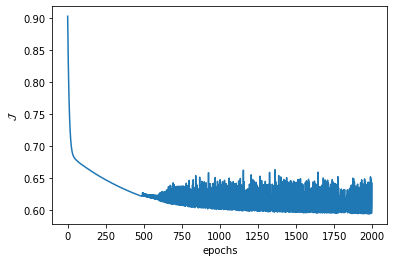

Training Accuracy: 0.6977
Test Accuracy: 0.6994


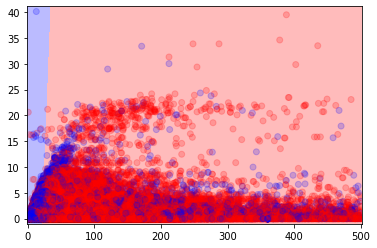

In [142]:
if __name__ =="__main__":
  main_class8()

###Balance the 0 and 1

In [87]:
shuffled_df = df1.sample(frac=1,random_state=4)

In [88]:
df1_0 = shuffled_df.loc[shuffled_df['passholder_type'] == 0]

In [111]:
df1_1 = shuffled_df.loc[shuffled_df['passholder_type'] == 1].sample(n=280000,random_state=42)

In [112]:
data_proc_balanced = pd.concat([df1_0, df1_1])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


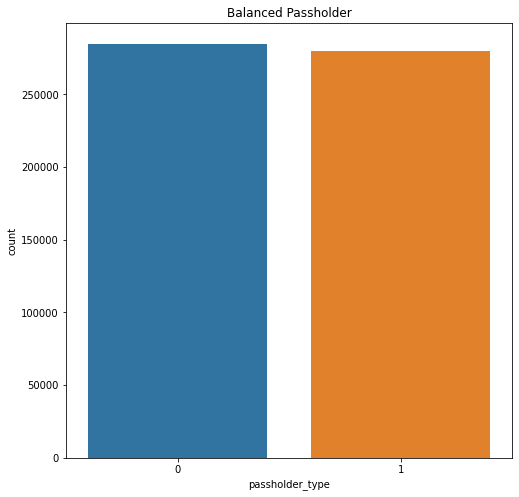

In [114]:
plt.figure(figsize=(8, 8))
sns.countplot('passholder_type', data=data_proc_balanced)
plt.title('Balanced Passholder')
plt.show()

In [122]:
# Shuffle your dataset 
shuffle_dfb = data_proc_balanced.sample(frac=1)

# Define a size for your train set 
train_sizeb = int(0.8 * len(data_proc_balanced))

# Split your dataset 
train_dfb = shuffle_dfb[:train_sizeb]
test_dfb = shuffle_dfb[train_sizeb:]

In [117]:
Xb = train_dfb.loc[:,['time','distance_km']]
yb = train_dfb.loc[:,'passholder_type']

In [143]:
Xb = Xb.to_numpy()
yb = yb.to_numpy()

In [144]:
X_testb = test_dfb.loc[:,['time','distance_km']]
y_testb = test_dfb.loc[:,'passholder_type']

In [145]:
X_testb = X_testb.to_numpy()
y_testb = y_testb.to_numpy()

In [146]:
def main_class3():
    D = 2
    K = 3
    N = int(K*1e3)
    

    ann=ANN([8, 8, 8],[ReLU, np.tanh, np.tanh])
    ann.fit(Xb,yb,eta =3e-2, epochs=2e3, show_curve=True)
    y_hatb = ann.predict(Xb)
    y_hattb = ann.predict(X_testb)

    print(f"Training Accuracy: {accuracy(yb, y_hatb):0.4f}")
    print(f"Test Accuracy: {accuracy(y_testb, y_hattb):0.4f}")
    
    x1 = np.linspace(X[:,0].min() - 1, X[:,0].max() + 1, 1000)
    x2 = np.linspace(X[:,1].min() - 1, X[:,1].max() + 1, 1000)
    
    xx1, xx2 = np.meshgrid(x1, x2)
    Z = ann.predict(np.c_[xx1.ravel(),xx2.ravel()]).reshape(*xx1.shape)
    
    plt.figure()
    plt.pcolormesh(xx1, xx2, Z, cmap = cmap_light)
    plt.scatter(X[:,0], X[:,1], c = y, cmap = cmap_bold,alpha=0.2)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plt.show()  

In [147]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Sep  7 03:20:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

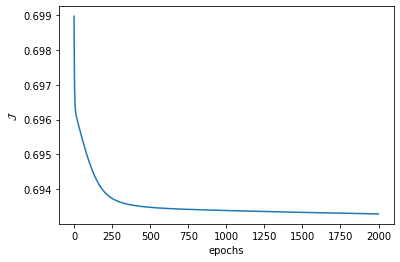

Training Accuracy: 0.5049
Test Accuracy: 0.5066


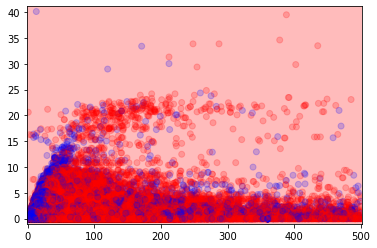

In [148]:
if __name__ =="__main__":
  main_class3()

###Other model